In [1]:
import os

import SimpleITK as sitk
import pydicom as pydicom

import numpy as np

from scipy.optimize import curve_fit, minimize

from scipy.signal import savgol_filter
from sklearn.metrics import r2_score

import pandas as pd

import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
from tqdm import tqdm

import math

In [2]:
from qiba import dce, dsc

In [3]:
import warnings
warnings.filterwarnings("ignore")

### Utils - T1w Singal to Concentration

In [4]:
def T1w_to_Con(T1w_t, T1_0, TR, FA_deg, r1, num_basepts=1):
    
    assert num_basepts>0, "need at least one time point for mean SI(t=0) computation"
    assert T1_0>0, "Assumed mean T1 value should be > 0"
    assert TR>0, "Repetition time should be > 0"
    assert r1>0, "relaxivity should be > 0"
    
    '''
    T1w_t - T x D x W x H
    T1_0 - Scalar
    TR - Scala; Repetition Time
    FA_deg - Flip Angle 
    
    
    '''
    
    #ref: https://qibawiki.rsna.org/images/1/1f/QIBA_DCE-MRI_Profile-Stage_1-Public_Comment.pdf
    
    e = 1e-12
    
    # t1w_t - array of motion corrected T1w combined in the order of acquisition time to form a single series as part of the dce acquisition
    # mask_t - is the ROI in 4D
    # (ms) T1_0 is the can be assumed/measured. In this case, we use the assumed mean T1 relaxation time for the tissue in consideration pre-contrast; for lungs T1 = 1200ms 
    # (ms) TR is the repitition time
    # FA_deg is the flip angle in degree
    # r1 is the relaxivity of the contrast agent
    # num_basepts - no of basepoints
    
    FA_rad = np.deg2rad(FA_deg) #because numpy requires radian as input
    
    E1_0 = np.exp(-TR/T1_0)
    B = (1-E1_0)/(1-np.cos(FA_rad)*E1_0)

    T1w_0 = T1w_t[:num_basepts].mean(axis=0) 
    
    A_t = B * (T1w_t)/(T1w_0 + e) # normalize by pre-contrast signal
    
    R1_0 = 1/T1_0 #baseline relation rate
    
    fraction = (1-A_t)/(1-np.cos(FA_rad) * A_t + e)
    
    R1_t = (-1/TR) * np.sign(fraction) * np.log(np.abs(fraction)) #to prevent negative values in the fraction when computing log
    
    delta_R1_t = R1_t - R1_0
    
    C_t = delta_R1_t/r1
    
    C_t[C_t<0] = 0
    
    return C_t
    

### Utils - Population AIFs

In [5]:
#Population AIF

def parker_aif(t):
    
    '''
    t in seconds
    
    implements the Parker Arterial Input Function (2005)
    Parker et al, Experimentally derived functional form for a
    population-averaged high temporal resolution arterial input function 
    for dynamic contrast enhanced MRI
    
    ref: http://wpage.unina.it/msansone/compartmentalModelling/parker.m
    ref: https://github.com/mjt320/SEPAL/blob/master/src/aifs.py
    ref: https://github.com/OSIPI/DCE-DSC-MRI_CodeCollection/blob/develop/src/original/PvH_NKI_NL/AIF/PopulationAIF.py

    '''
    
    #constants
    A1 = 0.809 #mmol.min
    A2 = 0.330 #mmol.min
    T1 = 0.17046 #min
    T2 = 0.365 #min
    sigma1 = 0.0563 #min
    sigma2 = 0.132 #min
    alpha = 1.050 #mmol
    beta = 0.1685 #min-1
    s = 38.078 #min-1
    tau = 0.483 #min
    
    #input
    t = t/60 # converting seconds to minutes; this function need minutes input
    
    Cp =  A1 * (1/(sigma1*np.sqrt(2*np.pi))) * np.exp(-(t-T1)**2/(2*sigma1**2)) + \
          A2 * (1/(sigma2*np.sqrt(2*np.pi))) * np.exp(-(t-T2)**2/(2*sigma2**2)) + \
          alpha * (np.exp(-beta * t) / (1 + np.exp(-s*(t-tau))))
    
    # Cp[t<0] = 0 by default Cp will be 0 for t<0
    
    return Cp


    
def weinmann_aif(t):
    
    #t in seconds; 
    #ref: http://wpage.unina.it/msansone/compartmentalModelling/weinmann.m
    
    
    t = t/60 # (t-t_start)/60
    
    #constants
    A1 = 3.99 # kg/L
    A2 = 4.78 # kg/L
    M1 = 0.144 #min-1
    M2 = 0.0111 #min-1
    D = 0.2 #mmol/kg

    Cp = D * ((A1 * np.exp(-M1 * t) + A2 * np.exp(-M2 * t)))
    Cp[t<0] = 0 # is important to shift aif
    
    return Cp

def georgiou_aif(t):
    
    #ref https://github.com/OSIPI/DCE-DSC-MRI_CodeCollection/blob/develop/src/original/PvH_NKI_NL/AIF/PopulationAIF.py
    #adapatation of Geourgiou et al. MRM 2018, doi: 10.1002/mrm.27524
    
    #constants
    a1=0.37 #mM
    m1=0.11 #min-1
    a2=0.33 #mM
    m2=1.17 #min-1
    a3=10.06 #mM
    m3=16.02 #min-1
    alpha=5.26
    beta=0.032 #min
    tau=0.129 #min
    
    t = t/60 #to minutes
    nt = len(t)
    
    no_circ = round(t[nt-1] / tau)
    Cb = np.zeros(nt)
    
    for current_circ in range(0, no_circ+1):
        if current_circ < no_circ:
            timeindex = np.where((t >= current_circ*tau) & (t < (current_circ+1)*tau))
        else:
            timeindex = np.where(t >= current_circ*tau)

        current_time = t[timeindex]

        ftot = np.zeros(len(timeindex))
        for k in range(0, current_circ+1):
            alphamod = (k + 1) * alpha + k
            timemod = current_time - k * tau
            f1 = np.power(timemod, alphamod) * np.exp(-timemod / beta)
            try:
                ans = math.gamma(alphamod + 1)
                f2 = np.power(beta, alphamod + 1) * math.gamma(alphamod + 1)  
                f3 = f1 / f2
                ftot = ftot + f3
            except OverflowError:
                ans = float('inf')

        exp1 = a1 * np.exp(-m1 * current_time)
        exp2 = a2 * np.exp(-m2 * current_time)
        exp3 = a3 * np.exp(-m3 * current_time)
        sumexp = np.add(exp1, exp2)
        sumexp = np.add(sumexp, exp3)
        Cb[timeindex] = sumexp*ftot
        
    # Cb[t<0] = 0 by default Cb will be 0 for t<0
        
    return Cb


def delay_corrected_aif(aif_fn, t_arr, t0):
    
    return aif_fn(t_arr-t0)
    

### Utils - Tofts Model

In [6]:
class StandardTofts(object):
    
    def __init__(self, Cp_t):
        
        self.Cp_t = Cp_t
        
    def __call__(self, t_arr, ktrans, ve):
        
        Ct_t = np.zeros_like(t_arr, dtype=np.float32)
        
        Cp_t = self.Cp_t
        
        for i,t in enumerate(t_arr):
            
            ti = t_arr[:i+1]
            Cp_ti = Cp_t[:i+1]
            
            Ct_t[i] = ktrans * np.trapz(Cp_ti * np.exp((-ktrans/ve)*(t-ti)), ti)
            
        return Ct_t
    
class ExtendedTofts(object):
    
    def __init__(self, Cp_t):
        
        self.Cp_t = Cp_t
        
    def __call__(self, t_arr, vp, ktrans, ve):
        
        Ct_t = np.zeros_like(t_arr, dtype=np.float32)
        Cp_t = self.Cp_t
        
        for i,t in enumerate(t_arr):

            ti = t_arr[:i+1]
            Cp_ti = Cp_t[:i+1]

            Ct_t[i] = vp * Cp_t[i] + ktrans * np.trapz(Cp_ti * np.exp(-(ktrans/ve)*(t-ti)), ti)

        return Ct_t
        


class delayCorrectedStandardTofts(object):
    
    def __init__(self, aif_fn):
        
        self.aif_fn = aif_fn 
        
    def __call__(self, t_arr, t0, ktrans, ve):
        
        #t0 is the bolus arrival time to account for the delay
        #the estimated Ktrans will be in sec-1
        #Ve is in percent

        Ct_t = np.zeros_like(t_arr, dtype=np.float32)
        
        Cp_t = self.aif_fn(t_arr-t0)
        
        for i,t in enumerate(t_arr):

            ti = t_arr[:i+1]
            Cp_ti = Cp_t[:i+1]

            Ct_t[i] = ktrans * np.trapz(Cp_ti * np.exp((-ktrans/ve)*(t-ti)), ti)

        return Ct_t
    
# Kep = -Ktrans/Ve


class delayCorrectedExtendedTofts(object):
    
    def __init__(self, aif_fn):
        
        self.aif_fn = aif_fn
        
    def __call__(self, t_arr, t0, vp, ktrans, ve):
        
        #t0 is the bolus arrival time to account for the delay
        #the estimated Ktrans will be in sec-1
        # Vp, Ve are in percent
        
        Ct_t = np.zeros_like(t_arr, dtype=np.float32)
        Cp_t = self.aif_fn(t_arr - t0)
        
        for i,t in enumerate(t_arr):

            ti = t_arr[:i+1]
            Cp_ti = Cp_t[:i+1]

            Ct_t[i] = vp * Cp_t[i] + ktrans * np.trapz(Cp_ti * np.exp((-ktrans/ve)*(t-ti)), ti)

        return Ct_t
    
# Kep = -Ktrans/Ve

### Utils - Bolus Arrival Time Estimation

In [7]:
def search_interval(S_t, method="min-max-refined"):

    #based on https://github.com/mstorath/DCEBE/blob/master/auxiliary/DCEBE_searchIntervals.m
    #S_t corresponds to the singal over time - T1w intensity or Contrast agent concentration

    assert method in ["none", "min-max", "min-max-refined"], "method shoud either be none or min-max or min-max-refined"

    # nt = len(S_t)

    min_lb = 0
    max_ub = len(S_t)-1

    if method == "min-max":

        lb = np.argmin(S_t)
        ub = np.argmax(S_t)

    elif method == "min-max-refined":

        lb = np.argmin(S_t)
        ub = np.argmax(S_t)
        
        if lb>ub: #because of noises
            lb = min_lb

        tr = np.mean([S_t[lb], S_t[ub]])
        ub_aux = np.argmin(np.abs(S_t[lb:ub+1] - tr))

        ub = max(0, ub_aux + lb - 1) #ensure that ub is atleast 0; for example if ub_aux = 0, lb=0, then ub = -1
            
    else:
        lb = min_lb
        ub = max_ub
        
    
    if lb>ub: #because of noice
        lb = min_lb


    return max(min_lb, lb), min(max_ub, ub)

In [8]:
class LinearLinear_BATModel(object):
    
    # bolus arrival time estimation using Linear-Linear (L-L) Model 
    # Implementation of https://iopscience.iop.org/article/10.1088/0031-9155/48/5/403/pdf
    
    
    def __init__(self,  k=-1):
        
        self.k = k
        
    def __call__(self, t_arr, b0, b1):
        
        t_k = t_arr[self.k]
    
        return np.piecewise(t_arr, [t_arr<t_k], [b0, lambda t:b0+b1*(t-t_k)])
    
    def run(self, t_arr, S_t, search_interval, verbose=False):
        
        assert len(search_interval)==2, "expects a tuple (lowerbound, upperbound) as search_interval"
        
        lb, ub = search_interval
        
        self.bat_index = lb
        
        if ub-lb>2:
            
            if verbose:
                print(f"Search interval - {lb} to {ub}")

            p = ub-lb

            X = t_arr[lb:ub+1]
            y = S_t[lb:ub+1]
            
            if verbose:
                plt.plot(t_arr, S_t, marker=".")

            SSE = np.ones(p) * np.inf

            for k in range(p):

                p_opt, _ = curve_fit(LinearLinear_BATModel(k), X, y)

                SSE[k] = np.sum((y-LinearLinear_BATModel(k)(X, *p_opt))**2)

                if verbose:
                    plt.plot(X, LinearLinear_BATModel(k)(X, *p_opt), "--")
        
            self.bat_index = np.argmin(SSE) + lb

        
        
        if verbose:
            plt.plot(t_arr[self.bat_index], S_t[self.bat_index], marker="v", color='black')
            plt.show()
            print("bat_index instance variable generated")
        
        return self

In [9]:
class LinearQuadratic_BATModel(object):
    
    # bolus arrival time estimation using piecewise Linear-Qudratic(L-Q) Model 
    # Implementation of https://iopscience.iop.org/article/10.1088/0031-9155/48/5/403/pdf
    
    
    def __init__(self, k=-1):
        
        self.k = k
    
        
    def __call__(self, t_arr, b0, b1, b2):
        
        t_k = t_arr[self.k]
    
        return np.piecewise(t_arr, [t_arr<t_k], [b0, lambda t:b0+b1*(t-t_k)+b2*(t-t_k)**2])
    
    def run(self, t_arr, S_t, search_interval, verbose=False):

        assert len(search_interval)==2, "expects a tuple (lowerbound, upperbound) as search_interval"
        
        lb, ub = search_interval
        
        self.bat_index = lb
        
        if ub-lb>2:
            
            if verbose:
                print(f"Search interval - {lb} to {ub}")

            p = ub-lb

            X = t_arr[lb:ub+1]
            y = S_t[lb:ub+1]
            
            if verbose:
                plt.plot(t_arr, S_t, marker=".")

            SSE = np.ones(p) * np.inf

            for k in range(p):

                p_opt, _ = curve_fit(LinearQuadratic_BATModel(k), X, y)

                SSE[k] = np.sum((y-LinearQuadratic_BATModel(k)(X, *p_opt))**2)

                if verbose:
                    plt.plot(X, LinearQuadratic_BATModel(k)(X, *p_opt), ".--")

            self.bat_index = np.argmin(SSE) + lb
        
        if verbose:
            plt.plot(t_arr[self.bat_index], S_t[self.bat_index], marker="v", color='black')
            plt.show()
            print("bat_index instance variable generated")
            
        return self

In [10]:
class PeakGradient_BATModel(object):
    
    # based on https://github.com/millerjv/PkModeling/blob/master/PkSolver/PkSolver.cxx
    
    def __init__(self, window_factor = 10, polynomial_order=1, threshold_factor=10):
        
        self.smoothing_params = {"window_factor":window_factor, "polynomial_order":polynomial_order}
        self.threshold_factor = threshold_factor
    
    def run(self, t_arr, S_t, search_interval=None, verbose=False):
        
        #search interval argument is not necessary but was defined to keep the approach consistent with others
        
        window_size = len(t_arr)//self.smoothing_params["window_factor"]

        polynomial_order = self.smoothing_params["polynomial_order"]
        
        # Step 1: Smoothing done using Savizky-Golay before this call on Signal or Conc. data
        S_t_smooth = savgol_filter(S_t, window_size+1 if window_size%2==0 else window_size , polynomial_order)#expects odd number as window_size
        
        # Step 2: Spatial derivative of smoothed data independent of ascent/descent
        dS_t_smooth = np.sqrt(np.gradient(S_t_smooth)**2)
        
        # Step 3: Find point of steepest descent/ascent
        max_slope = np.max(dS_t_smooth)

        # Step 4: BAT index detection
        threshold = max_slope/self.threshold_factor
        self.bat_index = np.argmax(dS_t_smooth > threshold) + 1
        
        
        if verbose:
            plt.plot(t_arr, S_t, marker=".")
            plt.plot(t_arr, S_t_smooth, ".--")
            plt.plot(t_arr[self.bat_index], S_t[self.bat_index], marker="v", color='black')
            print("bat_index instance variable generated")
        
        return self
        
        
        
        

### Sanity Check using LCB_BNI_USA Sample Data

In [11]:
import scipy.io
data = scipy.io.loadmat('qiba/data.mat')

T1_0 = data["tumor_T1"].item() 

TR = data["TR"].item() # in seconds

FA_deg = data["flip"].item()

r1 = 3.3 #L/mmol/sec

nt = 121
t_arr = TR * np.arange(nt)

tumor_T1w_t = data["tumor_SIt"][0]

true_bat_index = 40

# # Using the old equation from QIBA recommendation; to match the output of  
# S0_TE0 = np.mean(tumor_T1w_t[0:bat_index+1],axis=-1)
# R10 = 1 / T1_0
# S0 = ((np.exp(-R10 * TR) * np.cos(np.deg2rad(FA_deg)) * S0_TE0) - S0_TE0 / np.sin(np.deg2rad(FA_deg))) / (np.exp(-R10 * TR) - 1.)

# a = np.sin(np.deg2rad(FA_deg))*S0 - tumor_T1w_t
# b = np.sin(np.deg2rad(FA_deg))*S0 - np.cos(np.deg2rad(FA_deg))*tumor_T1w_t
# c = np.sin(np.deg2rad(FA_deg))*S0 - np.cos(np.deg2rad(FA_deg))*S0_TE0
# d = np.sin(np.deg2rad(FA_deg))*S0 - S0_TE0

# dR1 = (-1/TR) * np.log((a / b) * (c / d))
# tumor_C_t = dR1/r1

sub_aif_C_t = data["AIF_Ct"][0]

##### Check #1 - PK Modelling on original data (known BAT, known AIF)

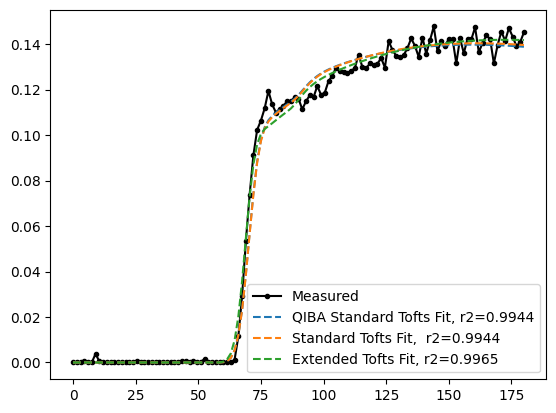

QIBA Standard Tofts Fit: Ktrans:0.1295 /min, Ve=0.1759
Standard Tofts Fit: Ktrans:0.1287 /min, Ve=0.1778
Extended Tofts Fit: Ktrans:0.12 /min, Ve=0.183, Vp=0.003292


In [12]:
Ct_t = T1w_to_Con(tumor_T1w_t, T1_0, TR, FA_deg, r1, num_basepts=10)
Cp_t = sub_aif_C_t #aif

qiba_ktrans_opt, qiba_ve_opt, qiba_Ct_t = dce.fit_tofts(t_arr, Ct_t, Cp_t)
qiba_r2 = r2_score(Ct_t, qiba_Ct_t)

#standard tofts
ktrans_0 = 0.058/60 #seconds-1
ve_0 = 0.2 #fractional volume

params_init = [ktrans_0, ve_0]
params_lower = (60e-12/60, 0.01)
params_upper = (3/60, 1)

params_opt, params_cov = curve_fit(StandardTofts(Cp_t), t_arr, Ct_t, p0=params_init, bounds = [params_lower, params_upper], maxfev=100000)
standard_ktrans_opt, standard_ve_opt = params_opt
standard_Ct_t = StandardTofts(Cp_t)(t_arr, *params_opt)
standard_r2 = r2_score(Ct_t, standard_Ct_t)


# extended
vp_0 = 0.0025 #fractional volume
ktrans_0 = 0.058/60 #in seconds-1
ve_0 = 0.2 #fractional volume
params_init = [vp_0, ktrans_0, ve_0]
params_lower = (1e-4, 60e-12/60, 0.01)
params_upper = (1.0, 3/60, 1.0)
params_opt, params_cov = curve_fit(ExtendedTofts(Cp_t), t_arr, Ct_t, p0=params_init, bounds = [params_lower, params_upper], maxfev=100000)#, bounds=bounds)
extended_vp_opt, extended_ktrans_opt, extended_ve_opt = params_opt
extended_Ct_t = ExtendedTofts(Cp_t)(t_arr, *params_opt)
extended_r2 = r2_score(Ct_t, extended_Ct_t)

plt.plot(t_arr, Ct_t, 'k.-', label="Measured")
plt.plot(t_arr, qiba_Ct_t, '--', label=f'QIBA Standard Tofts Fit, r2={qiba_r2:0.4}')
plt.plot(t_arr, standard_Ct_t, "--", label=f"Standard Tofts Fit,  r2={standard_r2:0.4}")
plt.plot(t_arr, extended_Ct_t, "--", label=f"Extended Tofts Fit, r2={extended_r2:0.4}")
plt.legend()
plt.show()

print(f"QIBA Standard Tofts Fit: Ktrans:{qiba_ktrans_opt:0.4} /min, Ve={qiba_ve_opt:0.4}")
print(f"Standard Tofts Fit: Ktrans:{standard_ktrans_opt*60:0.4} /min, Ve={standard_ve_opt:0.4}")
print(f"Extended Tofts Fit: Ktrans:{extended_ktrans_opt*60:0.4} /min, Ve={extended_ve_opt:0.4}, Vp={extended_vp_opt:0.4}")




##### Check #2 - Visualizing Arterial Input Functions - Sub AIF v/s Delay Corrected Population AIF

In [13]:
tumor_C_t = T1w_to_Con(tumor_T1w_t, T1_0, TR, FA_deg, r1, 10)

sub_aif_C_t = data["AIF_Ct"][0]
parker_aif_C_t= parker_aif(t_arr-t_arr[true_bat_index])
weinmann_aif_C_t = weinmann_aif(t_arr-t_arr[true_bat_index])
georgiou_aif_C_t = georgiou_aif(t_arr-t_arr[true_bat_index])

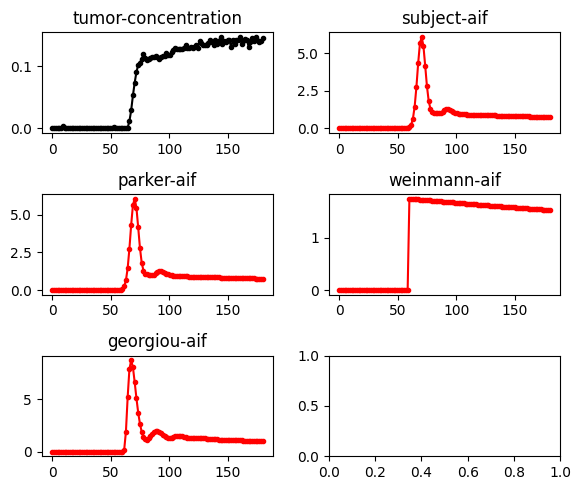

In [14]:
%matplotlib inline

fig,axs = plt.subplots(3,2, figsize=(6, 5))
axs[0,0].plot(t_arr, tumor_C_t, "k.-")
axs[0,0].set_title("tumor-concentration")
axs[0,1].plot(t_arr, sub_aif_C_t, "r.-")
axs[0,1].set_title("subject-aif")
axs[1,0].plot(t_arr, parker_aif_C_t, "r.-")
axs[1,0].set_title("parker-aif")
axs[1,1].plot(t_arr, weinmann_aif_C_t, "r.-")
axs[1,1].set_title("weinmann-aif")
axs[2,0].plot(t_arr, georgiou_aif_C_t, "r.-")
axs[2,0].set_title("georgiou-aif")
plt.tight_layout()
plt.show()

##### Check #3 - Automatic Estimation of BAT

True BAT = 60.0, LL BAT = 64.5, LQ BAT = 63.0, PG BAT = 58.5


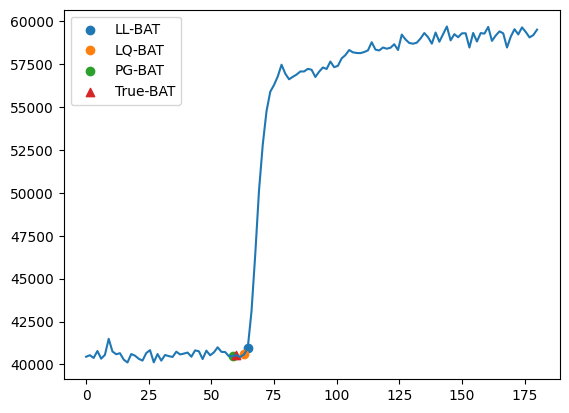

In [15]:
ll_bat_index = LinearLinear_BATModel().run(t_arr, tumor_T1w_t, search_interval(tumor_T1w_t)).bat_index
lq_bat_index = LinearQuadratic_BATModel().run(t_arr, tumor_T1w_t, search_interval(tumor_T1w_t)).bat_index
pg_bat_index = PeakGradient_BATModel().run(t_arr, tumor_T1w_t).bat_index

plt.plot(t_arr, tumor_T1w_t)
plt.scatter(t_arr[ll_bat_index], tumor_T1w_t[ll_bat_index], label="LL-BAT")
plt.scatter(t_arr[lq_bat_index], tumor_T1w_t[lq_bat_index], label="LQ-BAT")
plt.scatter(t_arr[pg_bat_index], tumor_T1w_t[pg_bat_index], label="PG-BAT")
plt.scatter(t_arr[true_bat_index], tumor_T1w_t[true_bat_index], label="True-BAT", marker="^")
plt.legend()

print(f"True BAT = {t_arr[true_bat_index]}, LL BAT = {t_arr[ll_bat_index]}, LQ BAT = {t_arr[lq_bat_index]}, PG BAT = {t_arr[pg_bat_index]}") 

##### Check #4 -  delayCorrected PK Modelling when missing sub_aif and unknown BAT; initial BAT value determined using BAT estimation methods

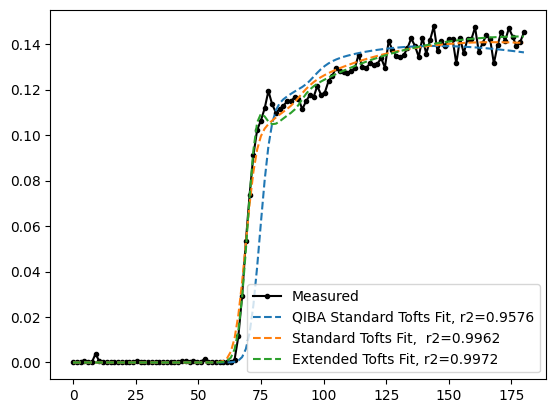

QIBA Standard Tofts Fit: t0:64.5, Ktrans:0.1404 /min, Ve=0.1661
Standard Tofts Fit: t0:58.69, Ktrans:0.1244 /min, Ve=0.1822
Extended Tofts Fit: t0:61.72, Ktrans:0.1138 /min, Ve=0.1852, Vp=0.007473


In [16]:
Ct_t = T1w_to_Con(tumor_T1w_t, T1_0, TR, FA_deg, r1, num_basepts=10)
aif_fn = parker_aif

#estimated bat index
bat_index = LinearLinear_BATModel().run(t_arr, tumor_T1w_t, search_interval(tumor_T1w_t)).bat_index

#conventional, pk equation donot offset for delay correction
qiba_ktrans_opt, qiba_ve_opt, qiba_Ct_t = dce.fit_tofts(t_arr, Ct_t, aif_fn(t_arr-t_arr[bat_index]))
qiba_r2 = r2_score(Ct_t, qiba_Ct_t)

#delay corrected standard tofts
t0_0 = t_arr[bat_index]
ktrans_0 = 0.058/60 #seconds-1
ve_0 = 0.2 #fractional volume

params_init = [t0_0, ktrans_0, ve_0]
params_lower = (-300.0, 60e-12/60, 0.01)
params_upper = (300.0, 3/60, 1)

standard_params_opt, params_cov = curve_fit(delayCorrectedStandardTofts(aif_fn), t_arr, Ct_t, p0=params_init, bounds = [params_lower, params_upper])
standard_t0_opt, standard_ktrans_opt, standard_ve_opt = standard_params_opt
standard_Ct_t = delayCorrectedStandardTofts(aif_fn)(t_arr, *standard_params_opt)
standard_r2 = r2_score(Ct_t, standard_Ct_t)


# delay corrected extended tofts
t0_0 = t_arr[bat_index]
vp_0 = 0.0025 #fractional volume
ktrans_0 = 0.058/60 #in seconds
ve_0 = 0.2 #fractional volume
params_init = [t0_0, vp_0, ktrans_0, ve_0]
params_lower = (-300.0, 1e-4, 60e-12/60, 0.01)
params_upper = (300.0, 1.0, 3/60, 1.0)
extended_params_opt, params_cov = curve_fit(delayCorrectedExtendedTofts(aif_fn), t_arr, Ct_t, p0=params_init, bounds = [params_lower, params_upper])#, bounds=bounds)
extended_t0_opt, extended_vp_opt, extended_ktrans_opt, extended_ve_opt = extended_params_opt
extended_Ct_t = delayCorrectedExtendedTofts(aif_fn)(t_arr, *extended_params_opt)
extended_r2 = r2_score(Ct_t, extended_Ct_t)

plt.plot(t_arr, Ct_t, 'k.-', label="Measured")
plt.plot(t_arr, qiba_Ct_t, '--', label=f'QIBA Standard Tofts Fit, r2={qiba_r2:0.4}')
plt.plot(t_arr, standard_Ct_t, "--", label=f"Standard Tofts Fit,  r2={standard_r2:0.4}")
plt.plot(t_arr, extended_Ct_t, "--", label=f"Extended Tofts Fit, r2={extended_r2:0.4}")
plt.legend()
plt.show()

print(f"QIBA Standard Tofts Fit: t0:{t_arr[bat_index]:0.4}, Ktrans:{qiba_ktrans_opt:0.4} /min, Ve={qiba_ve_opt:0.4}")
print(f"Standard Tofts Fit: t0:{standard_t0_opt:0.4}, Ktrans:{standard_ktrans_opt*60:0.4} /min, Ve={standard_ve_opt:0.4}")
print(f"Extended Tofts Fit: t0:{extended_t0_opt:0.4}, Ktrans:{extended_ktrans_opt*60:0.4} /min, Ve={extended_ve_opt:0.4}, Vp={extended_vp_opt:0.4}")



### Sanity Check Sample Lung Data - Mean Tumor Signal

In [17]:
DCE_DIR = "/home/thulasiseetha/research/dataset/curated/LungMR/dce"

In [18]:
time_arr = np.load("timeArray.npy", allow_pickle=True).item()

stat_df = pd.read_csv("stat_df.csv")

stat_df.head()

,pid,ref_id,age,sex,weight,height,contrast_agent,slice_thickness,voxel_spacing,img_matrix,...,TE,FA,FOV,num_of_phases,acquisition_period,manufacturer,version,field_strength,pdl1>=1%,pdl1>=50%
0,2021064,paz40,067Y,F,49,1.69,DOTAREM,3,"[3.12, 3.12, 3.0]","[128, 128, 32]",...,0.74,25,"[400.0, 400.0, 96.0]",30,1.47,SIEMENS,syngo MR E11,1.5,1,1
1,2565228,paz9,060Y,M,88,1.80,DOTAREM,3,"[3.12, 3.12, 3.0]","[128, 128, 36]",...,0.73,25,"[400.0, 400.0, 108.0]",30,1.54,SIEMENS,syngo MR E11,1.5,0,0
2,2780061,paz3,056Y,M,84,1.75,DOTAREM,3,"[3.12, 3.12, 3.0]","[128, 128, 32]",...,0.74,25,"[400.0, 400.0, 96.0]",30,1.47,SIEMENS,syngo MR E11,1.5,0,0
3,2737310,paz35,070Y,M,82,1.75,DOTAREM,3,"[3.12, 3.12, 3.0]","[128, 128, 36]",...,0.73,25,"[400.0, 400.0, 108.0]",30,1.54,SIEMENS,syngo MR E11,1.5,1,0
4,2776694,paz24,067Y,M,65,1.00,DOTAREM,3,"[3.0, 3.0, 3.0]","[128, 128, 32]",...,0.74,25,"[384.0, 384.0, 96.0]",30,1.47,SIEMENS,syngo MR E11,1.5,0,0


In [19]:
sample_ids = stat_df.ref_id.to_list()

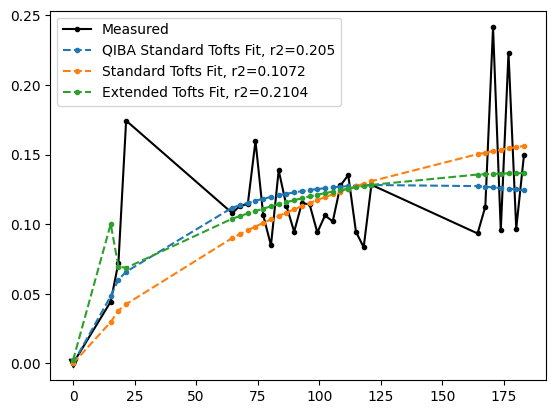

QIBA Standard Tofts Fit: t0:0.0, Ktrans:0.1447 /min, Ve=0.1774
Standard Tofts Fit: t0:0.07514231002849436, Ktrans: 0.08694 /min, Ve=0.3594
Extended Tofts Fit: t0:-1.7572397526949762e-06, Ktrans:0.08388 /min, Ve=0.2079, Vp=0.028


In [20]:
sample_id = "paz1"

row_dict = stat_df[stat_df.ref_id==sample_id].iloc[0].to_dict()

aif_fn = parker_aif

T1_0 = 1200 * 1e-3  #original in milliseconds https://pubmed.ncbi.nlm.nih.gov/28027756 to seconds

TR = row_dict["TR"] * 1e-3  # in milliseconds to seconds #not really patient specific, from an arbitrary patient

FA_deg = row_dict["FA"] #this is not exactly patient specific, value from an arbitrary patient

r1 = 3.6 #L/mmol/sec

t_arr = time_arr[sample_id]

nt = len(t_arr)

sitk_img = sitk.ReadImage(os.path.join(DCE_DIR, "images", sample_id, "mc_img4D.nii.gz"))
sitk_tumor_mask = sitk.JoinSeries([sitk.ReadImage(os.path.join(DCE_DIR, "masks", sample_id, "mask.nii.gz"))]*nt)


img_arr = sitk.GetArrayFromImage(sitk_img)
tumor_mask_arr = sitk.GetArrayFromImage(sitk_tumor_mask)

tumor_img_arr = np.ma.array(img_arr, mask=(tumor_mask_arr==0))
tumor_T1w_t = np.ma.mean(tumor_img_arr, axis=(1,2,3)).data# np.ma.masked_array(img_arr, tumor_mask_arr==0).mean(axis=(1,2,3)).data

bat_index = LinearLinear_BATModel().run(t_arr, tumor_T1w_t, search_interval(tumor_T1w_t)).bat_index

Ct_t = T1w_to_Con(tumor_T1w_t, T1_0, TR, FA_deg, r1, 1)

qiba_ktrans_opt, qiba_ve_opt, qiba_Ct_t = dce.fit_tofts(t_arr, Ct_t, aif_fn(t_arr-t_arr[bat_index]))
qiba_r2 = r2_score(Ct_t, qiba_Ct_t)

# delay corrected standard Tofts
t0_0 = t_arr[bat_index]
ktrans_0 = 0.058/60 #seconds-1
ve_0 = 0.2 #fractional volume

p_init = [t0_0, ktrans_0, ve_0]
p_lower = (-300.0, 60e-12/60, 0.01)
p_upper = (300.0, 3/60, 1)

p_opt, p_cov = curve_fit(delayCorrectedStandardTofts(aif_fn), t_arr, Ct_t, p0=p_init, bounds = [p_lower, p_upper], maxfev=100000)#, bounds=bounds)
standard_t0_opt, standard_ktrans_opt, standard_ve_opt = p_opt
standard_Ct_t = delayCorrectedStandardTofts(aif_fn)(t_arr, *p_opt)
standard_r2 = r2_score(Ct_t, standard_Ct_t)

# extended
t0_0 = t_arr[bat_index]
vp_0 = 0.0025 #fractional volume
ktrans_0 = 0.058/60 #in seconds-1
ve_0 = 0.2 #fractional volume

p_init = [t0_0, vp_0, ktrans_0, ve_0]
p_lower = (-300.0, 1e-4, 60e-12/60, 0.01)
p_upper = (300.0, 1.0, 3/60, 1.0)


p_opt, p_cov = curve_fit(delayCorrectedExtendedTofts(aif_fn), t_arr, Ct_t, p0=p_init, bounds = [p_lower, p_upper], maxfev=100000)#, bounds=bounds)
extended_t0_opt, extended_vp_opt, extended_ktrans_opt, extended_ve_opt = p_opt
extended_Ct_t = delayCorrectedExtendedTofts(aif_fn)(t_arr, *p_opt)
extended_r2 = r2_score(Ct_t, extended_Ct_t)

plt.plot(t_arr, Ct_t, 'k.-', label="Measured")
plt.plot(t_arr, qiba_Ct_t, '.--', label=f'QIBA Standard Tofts Fit, r2={qiba_r2:0.4}')
plt.plot(t_arr, standard_Ct_t, ".--", label=f"Standard Tofts Fit, r2={standard_r2:0.4}")
plt.plot(t_arr, extended_Ct_t, ".--", label=f"Extended Tofts Fit, r2={extended_r2:0.4}")
plt.scatter(t_arr[bat_index], Ct_t[bat_index], marker="v", color='black')
plt.legend()
plt.show()

print(f"QIBA Standard Tofts Fit: t0:{t_arr[bat_index]}, Ktrans:{qiba_ktrans_opt:0.4} /min, Ve={qiba_ve_opt:0.4}")
print(f"Standard Tofts Fit: t0:{standard_t0_opt}, Ktrans: {standard_ktrans_opt*60:0.4} /min, Ve={standard_ve_opt:0.4}")
print(f"Extended Tofts Fit: t0:{extended_t0_opt}, Ktrans:{extended_ktrans_opt*60:0.4} /min, Ve={extended_ve_opt:0.4}, Vp={extended_vp_opt:0.2}")



### Sanity Check Sample Lung Data - Voxel-wise

In [21]:
sample_id = "paz1" #sample_ids[0] paz16

row_dict = stat_df[stat_df.ref_id==sample_id].iloc[0].to_dict()

aif_fn = parker_aif

T1_0 = 1200 * 1e-3  #original in milliseconds https://pubmed.ncbi.nlm.nih.gov/28027756 to seconds

TR = row_dict["TR"] * 1e-3  # in milliseconds to seconds #not really patient specific, from an arbitrary patient

FA_deg = row_dict["FA"] #this is not exactly patient specific, value from an arbitrary patient

r1 = 3.6 #L/mmol/sec

t_arr = time_arr[sample_id]

nt = len(t_arr)

sitk_img = sitk.ReadImage(os.path.join(DCE_DIR, "images", sample_id, "mc_img4D.nii.gz"))
sitk_tumor_mask = sitk.ReadImage(os.path.join(DCE_DIR, "masks", sample_id, "mask.nii.gz"))

img_arr = sitk.GetArrayFromImage(sitk_img)
tumor_mask_arr = sitk.GetArrayFromImage(sitk_tumor_mask)

tumor_img_arr = np.ma.array(img_arr, mask=(np.stack([tumor_mask_arr]*nt)==0))
tumor_T1w_t = np.ma.mean(tumor_img_arr, axis=(1,2,3)).data# np.ma.masked_array(img_arr, tumor_mask_arr==0).mean(axis=(1,2,3)).data

bat_index = LinearLinear_BATModel().run(t_arr, tumor_T1w_t, search_interval(tumor_T1w_t)).bat_index #This way of initialization gives better fit, no convergence error

img_arr = sitk.GetArrayFromImage(sitk_img) #TxDxWxH
tumor_mask_arr = sitk.GetArrayFromImage(sitk_tumor_mask)

D, W, H = tumor_mask_arr.shape

ktrans_map = np.zeros_like(tumor_mask_arr, dtype=np.float32)
ve_map = np.zeros_like(tumor_mask_arr, dtype=np.float32)
kep_map = np.zeros_like(tumor_mask_arr, dtype=np.float32)
t0_map = np.zeros_like(tumor_mask_arr, dtype=np.float32)
r2_map = np.zeros_like(tumor_mask_arr, dtype=np.float32)

d_indeces, w_indeces, h_indeces = np.nonzero(tumor_mask_arr)

num_voxels = len(d_indeces) # or len(w_indeces)
pbar = tqdm(range(num_voxels), position=0, desc="processing voxels")
    
for d,w,h in zip(d_indeces, w_indeces, h_indeces):

    voxel_T1w_t = img_arr[:, d, w, h]
    
    # delay corrected standard Tofts
    t0_0 = t_arr[bat_index]
    ktrans_0 = 0.058/60 #seconds-1
    ve_0 = 0.2 #fractional volume

    p_init = [t0_0, ktrans_0, ve_0]
    p_lower = (-300.0, 60e-12/60, 0.01)
    p_upper = (300.0, 3/60, 1)
    
    # Converting T1w to Concentration
    voxel_C_t = T1w_to_Con(voxel_T1w_t, T1_0, TR, FA_deg, r1, 1)

    # PK Modelling and param estimation
    p_opt, p_cov = curve_fit(delayCorrectedStandardTofts(aif_fn), t_arr, voxel_C_t, p0 = p_init, bounds = [p_lower, p_upper], maxfev=100000)
    fitted_voxel_C_t = delayCorrectedStandardTofts(aif_fn)(t_arr, *p_opt)
    
    r2 = r2_score(voxel_C_t, fitted_voxel_C_t)
    
    t0, ktrans, ve = p_opt #ktrans in sec -1
    kep = ktrans/ve #kep in sec -1
    
    r2_map[d, w, h] = r2
    ktrans_map[d, w, h] = ktrans * 60
    ve_map[d, w, h] = ve
    kep_map[d, w, h] = kep * 60
    t0_map[d, w, h] = t0
    
    pbar.update()


processing voxels: 100%|███████████████████████████████████████████████████████████████████████| 837/837 [00:25<00:00, 33.35it/s]

##### Visualization

In [22]:
def display_slice(map_arr, i):
    
    plt.imshow(map_arr[i], cmap="jet", vmin=map_arr.min(), vmax=map_arr.max())
    plt.colorbar()
    plt.show()
    
def visualize(map_arr):
    
    widgets.interact(lambda i:display_slice(map_arr, i), i=widgets.IntSlider(0, min=0, max=len(map_arr)-1, step=1))

In [23]:
print(f"ktrans, median={np.percentile(ktrans_map[r2_map>0],50)}, 90thPercentile={np.percentile(ktrans_map[r2_map>0],90)}, std={np.std(ktrans_map[r2_map>0]):0.4}") #compare this with the global signal

visualize(ktrans_map)

ktrans, median=0.10708203166723251, 90thPercentile=0.4477788329124454, std=0.1931


interactive(children=(IntSlider(value=0, description='i', max=95), Output()), _dom_classes=('widget-interact',…